# Chapter 1. Domain Modeling Excercise

- Author: Joseph Kim

## Overview

### Context diagram for the allocation service

MADE.com is a successful furniture retailer. We source our furniture from manufacturers all over the world and sell it across Europe.

We have separate systems that are responsible for

- buying stock, 
- selling stock to customers, 
- and shipping goods to customers. 

A system in the middle needs to coordinate the process by allocating stock to a customer’s orders;

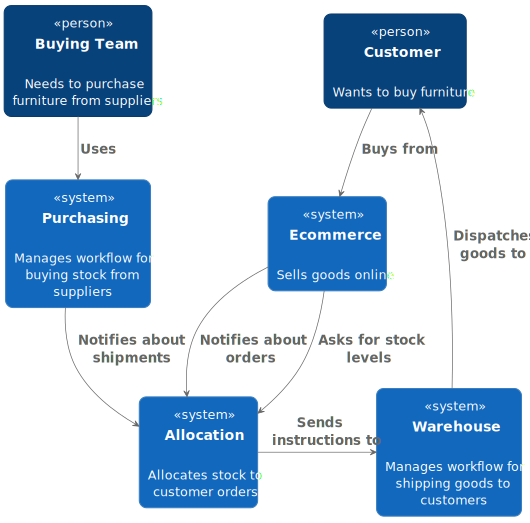

In [1]:
%%plantuml

@startuml allocation
!include images/C4_Context.puml
scale 0.7

System(systema, "Allocation", "Allocates stock to customer orders")

Person(customer, "Customer", "Wants to buy furniture")
Person(buyer, "Buying Team", "Needs to purchase furniture from suppliers")

System(procurement, "Purchasing", "Manages workflow for buying stock from suppliers")
System(ecom, "Ecommerce", "Sells goods online")
System(warehouse, "Warehouse", "Manages workflow for shipping goods to customers")

Rel(buyer, procurement, "Uses")
Rel(procurement, systema, "Notifies about shipments")
Rel(customer, ecom, "Buys from")
Rel(ecom, systema, "Asks for stock levels")
Rel(ecom, systema, "Notifies about orders")
Rel_R(systema, warehouse, "Sends instructions to")
Rel_U(warehouse, customer, "Dispatches goods to")

@enduml

<style>
.usecase { border-radius: 3px; border: 1px silver solid; background: #ddd; padding: 5px 8px }
</style>

## Exploring the Domain Language

##### Customers place *orders* for *products*.

- **Product**
  - identified by *SKU*(Stock Keeping Unit)
- **Order**
  - identified by an *order reference* 
  - comprises mutliple *order lines*
- **OrderLine**
  - has a *SKU* and a *quantity*
  
##### The purchasing department orders small *batches* of stock

- **Batch**
  - has a unique ID(*reference*), a *SKU*, and a *quantity* 
  - has an ETA if they are currently shipping
    - or they may be in *warehouse stock*.
  
##### We need to **allocate** *order lines* to *batches*.

- When we allocate x units of stock to a batch, the *available quantity* is reduced by x.

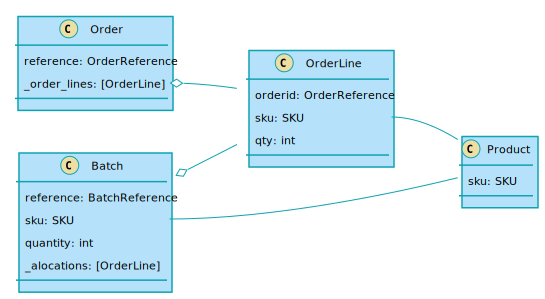

In [2]:
%%plantuml

@startuml

left to right direction

class Product {
    sku: SKU
}

class Order {
    reference: OrderReference
    _order_lines: [OrderLine]
}

class OrderLine {
    orderid: OrderReference
    sku: SKU
    qty: int
}

class Batch {
    reference: BatchReference
    sku: SKU
    quantity: int
    _alocations: [OrderLine]
}

Order::_order_lines o-- OrderLine
Batch::_allocations o-- OrderLine
OrderLine::sku -- Product
Batch::sku -- Product

@enduml

## Unit Testing Domain Models

In [3]:
# 단위 테스트를 위한 헬퍼 데코레이터

import sys
import traceback

import pytest

VIOLET = '\033[95m'
ENDC = '\033[0m'
BOLD = '\033[1m'

def test(func):
    try:
        func() # 함수를 정의할때 바로 실행되도록
        print(f'✔️ {VIOLET}{func.__name__}{ENDC}')
    except:
        exc_args = sys.exc_info()
        traceback.print_exception(*exc_args, limit=-1)
    finally:
        # 함수 실행이 실패해도 함수 정의는 그대로 리턴하도록
        return func

#### A first test for allocation

`Batch` 도메인이 정의되지 않아서 테스트가 실패합니다.

In [4]:
@test
def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine('order-ref', "SMALL-TABLE", 2)

    batch.allocate(line)

    assert batch.available_quantity == 18

Traceback (most recent call last):
  File "<ipython-input-4-ec9a4771936d>", line 3, in test_allocating_to_a_batch_reduces_the_available_quantity
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
NameError: name 'Batch' is not defined


#### First cut of a domain model for batches

In [5]:
%%typecheck domain_models1

from dataclasses import dataclass
from typing import Optional
from datetime import date

@dataclass(frozen=True)
class OrderLine:
    orderid: str
    sku: str
    qty: int


class Batch:
    def __init__(
        self, ref: str, sku: str, qty: int, eta: Optional[date]
    ):
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self.available_quantity = qty

    def allocate(self, line: OrderLine) -> None:
        self.available_quantity -= line.qty

Typecheck: success


도메인 객체 정의 후 테스트 성공합니다.

In [6]:
@test
def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine('order-ref', "SMALL-TABLE", 2)

    batch.allocate(line)

    assert batch.available_quantity == 18

✔️ test_allocating_to_a_batch_reduces_the_available_quantity


#### Testing logic for what we can allocate

`can_allocate` 가 정의되지 않아 실패하는 테스트 코드를 먼저 작성합니다.

In [7]:
def make_batch_and_line(sku, batch_qty, line_qty):
    return (
        Batch("batch-001", sku, batch_qty, eta=date.today()),
        OrderLine("order-123", sku, line_qty)
    )

@test
def test_can_allocate_if_available_greater_than_required():
    large_batch, small_line = make_batch_and_line("ELEGANT-LAMP", 20, 2)
    assert large_batch.can_allocate(small_line)

Traceback (most recent call last):
  File "<ipython-input-7-9ae6c0e6fdad>", line 10, in test_can_allocate_if_available_greater_than_required
    assert large_batch.can_allocate(small_line)
AttributeError: 'Batch' object has no attribute 'can_allocate'


테스트가 성공하도록 `Batch` 객체에 `can_allocate`를 정의합니다.

In [8]:
%%typecheck batch_alloc from domain_models1
from datetime import date

class Batch:
    def __init__(
        self, ref: str, sku: str, qty: int, eta: Optional[date]
    ):
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self._purchased_quantity = qty
        self._allocations = set[OrderLine]()

    def allocate(self, line: OrderLine) -> None:
        if self.can_allocate(line):
            self._allocations.add(line)

    def deallocate(self, line: OrderLine) -> None:
        if line in self._allocations:
            self._allocations.remove(line)

    @property
    def allocated_quantity(self) -> int:
        return sum(line.qty for line in self._allocations)

    @property
    def available_quantity(self) -> int:
        return self._purchased_quantity - self.allocated_quantity

    def can_allocate(self, line: OrderLine) -> bool:
        return self.sku == line.sku and self.available_quantity >= line.qty

Typecheck: success


테스트 성공

In [9]:
@test
def test_can_allocate_if_available_greater_than_required():
    large_batch, small_line = make_batch_and_line("ELEGANT-LAMP", 20, 2)
    assert large_batch.can_allocate(small_line)

@test
def test_cannot_allocate_if_available_smaller_than_required():
    small_batch, large_line = make_batch_and_line("ELEGANT-LAMP", 2, 20)
    assert small_batch.can_allocate(large_line) is False

@test
def test_can_allocate_if_available_equal_to_required():
    batch, line = make_batch_and_line("ELEGANT-LAMP", 2, 2)
    assert batch.can_allocate(line)

@test
def test_cannot_allocate_if_skus_do_not_match():
    batch = Batch("batch-001", "UNCOMFORTABLE-CHAIR", 100, eta=None)
    different_sku_line = OrderLine("order-123", "EXPENSIVE-TOASTER", 10)
    assert batch.can_allocate(different_sku_line) is False

✔️ test_can_allocate_if_available_greater_than_required
✔️ test_cannot_allocate_if_available_smaller_than_required
✔️ test_can_allocate_if_available_equal_to_required
✔️ test_cannot_allocate_if_skus_do_not_match


#### Test deallocation

In [10]:
@test
def test_can_only_deallocate_allocated_lines():
    batch, unallocated_line = make_batch_and_line("DECORATIVE-TRINKET", 20, 2)
    batch.deallocate(unallocated_line)
    assert batch.available_quantity == 20

✔️ test_can_only_deallocate_allocated_lines


In [11]:
@test
def test_allocation_is_idempotent():
    batch, line = make_batch_and_line("ANGULAR-DESK", 20, 2)
    batch.allocate(line)
    batch.allocate(line)
    assert batch.available_quantity == 18

✔️ test_allocation_is_idempotent


#### More types for more type hints

In [12]:
%%typecheck custom_types from batch_alloc
from typing import NewType

Quantity = NewType("Quantity", int)
Sku = NewType("Sku", str)
Reference = NewType("Reference", str)
OrderReference = NewType("OrderReference", str)
ProductReference = NewType("ProductReference", str)

Typecheck: success


#### OrderLine is a value object

In [13]:
%%typecheck orderline from custom_types

@dataclass(frozen=True)
class OrderLine:
    orderid: OrderReference
    sku: Sku
    qty: Quantity

Typecheck: success


#### More examples of value objects

In [14]:
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple

@dataclass(frozen=True)
class Name:
    first_name: str
    surname: str

class Money(NamedTuple):
    currency: str
    value: int

Line = namedtuple('Line', ['sku', 'qty'])

In [15]:
@test
def test_equality():
    assert Money('gbp', 10) == Money('gbp', 10)
    assert Name('Harry', 'Percival') != Name('Bob', 'Gregory')
    assert Line('RED-CHAIR', 5) == Line('RED-CHAIR', 5)

✔️ test_equality


#### Math with value objects

In [16]:
fiver = Money('gbp', 5)
tenner = Money('gbp', 10)

@test
def can_add_money_values_for_the_same_currency():
    assert fiver + fiver == tenner

Traceback (most recent call last):
  File "<ipython-input-16-3e32c9afbc08>", line 6, in can_add_money_values_for_the_same_currency
    assert fiver + fiver == tenner
AssertionError


##### Magic methods to support arithmetic operations between value objects 

In [17]:
class Money(NamedTuple):
    currency: str
    value: int
        
    def __add__(self, rhs: Money):
        if self.currency != rhs.currency: raise ValueError
        return Money(self.currency, self.value + rhs.value)
    
    def __sub__(self, rhs: Money):
        assert self.currency == rhs.currency
        return Money(self.currency, self.value - rhs.value)
    
    def __mul__(self, rhs: int):
        if not isinstance(rhs, (int, float)):
            raise TypeError
        return Money(self.currency, self.value * rhs)            

In [18]:
fiver = Money('gbp', 5)
tenner = Money('gbp', 10)        

@test
def can_add_money_values_for_the_same_currency():
    assert fiver + fiver == tenner
        
@test
def can_subtract_money_values():
    assert tenner - fiver == fiver

@test
def adding_different_currencies_fails():
    with pytest.raises(ValueError):
        Money('usd', 10) + Money('gbp', 10)

@test
def can_multiply_money_by_a_number():
    assert fiver * 5 == Money('gbp', 25)

@test
def multiplying_two_money_values_is_an_error():
    with pytest.raises(TypeError):
        tenner * fiver    

✔️ can_add_money_values_for_the_same_currency
✔️ can_subtract_money_values
✔️ adding_different_currencies_fails
✔️ can_multiply_money_by_a_number
✔️ multiplying_two_money_values_is_an_error


### Value Objects and Entities

#### A name itsetlf cannot change...

In [19]:
@test
def test_name_equality():
    assert Name("Harry", "Percival") != Name("Barry", "Percival")

✔️ test_name_equality


#### But a person can!

엔티티는 값과 달리 특정 id 속성값으로 동등성을 검사합니다. 객체 속성 바뀌어도 id가 같다면 같은 객체입니다. 

In [20]:
class Person:
    def __init__(self, name: Name):
        self.name = name

In [21]:
@test
def test_barry_is_harry():
    harry = Person(Name("Harry", "Percival"))
    barry = harry
    
    barry.name = Name("Barry", "Percival")
    
    assert harry is barry and barry is harry

✔️ test_barry_is_harry


#### Implementing equality opeartors

In [22]:
@test
def test_batch_equality():
    batch1 = Batch('batch-001', 'SIMPLE-TABLE', 10, eta=date.today())
    batch2 = Batch('batch-001', 'SIMPLE-CHAIR', 5, eta=date.today())
    
    assert batch1 == batch2

Traceback (most recent call last):
  File "<ipython-input-22-7e6a1737e553>", line 6, in test_batch_equality
    assert batch1 == batch2
AssertionError


`Batch` 엔티티에도 동일성을 검사할 수 있는 매직 메소드를 추가해봅시다.

In [23]:
%%typecheck batch_entity from custom_types, orderline
from datetime import date

class Batch:
    def __init__(
        self, ref: Reference, sku: Sku, qty: int, eta: Optional[date]
    ):
        self.__reference = ref
        self.sku = sku
        self.eta = eta
        self._purchased_quantity = qty
        self._allocations = set[OrderLine]()
        
    @property
    def reference(self) -> Reference:
        return self.__reference

    def allocate(self, line: OrderLine) -> None:
        if self.can_allocate(line):
            self._allocations.add(line)

    def deallocate(self, line: OrderLine) -> None:
        if line in self._allocations:
            self._allocations.remove(line)

    @property
    def allocated_quantity(self) -> int:
        return sum(line.qty for line in self._allocations)

    @property
    def available_quantity(self) -> int:
        return self._purchased_quantity - self.allocated_quantity

    def can_allocate(self, line: OrderLine) -> bool:
        return self.sku == line.sku and self.available_quantity >= line.qty
    
    #######################################################################    
    def __eq__(self, other: object) -> bool:
        if not isinstance(other, Batch):
            return False
        return other.reference == self.reference
    
    def __hash__(self) -> int:
        return hash(self.reference)

Typecheck: success


In [24]:
@test
def test_batch_equality():
    batch1 = Batch('batch-001', 'SIMPLE-TABLE', 10, eta=date.today())
    batch2 = Batch('batch-001', 'SIMPLE-CHAIR', 5, eta=date.today())
    
    assert batch1 == batch2

✔️ test_batch_equality


## Not Everything Has to Be an Object: A Domain Service Function

### Testing our domain services

정의되지 않은 `allocate` 함수(서비스)에 대한 실패하는 테스트를 먼저 작성합니다.

In [25]:
from datetime import date, timedelta
tomorrow = date.today() + timedelta(days=1)

@test
def test_prefers_current_stock_batches_to_shipments():
    in_stock_batch = Batch("in-stock-batch", "RETRO-CLOCK", 100, eta=None)
    shipment_batch = Batch("shipment-batch", "RETRO-CLOCK", 100, eta=tomorrow)
    line = OrderLine("oref", "RETRO-CLOCK", 10)

    allocate(line, [in_stock_batch, shipment_batch])

    assert in_stock_batch.available_quantity == 90
    assert shipment_batch.available_quantity == 100

Traceback (most recent call last):
  File "<ipython-input-25-c27cf706fffa>", line 10, in test_prefers_current_stock_batches_to_shipments
    allocate(line, [in_stock_batch, shipment_batch])
NameError: name 'allocate' is not defined


### A standalone function for our domain service

`Batch` 객체의 순서를 정의할 수 없으므로 `sorted` 를 적용할 수 없어 에러 발생합니다.

In [26]:
%%typecheck allocate from orderline, batch_entity
from typing import List

def allocate(line: OrderLine, batches: List[Batch]) -> str:
    batch = next(
        b for b in sorted(batches) if b.can_allocate(line)
    )
    batch.allocate(line)
    return batch.reference

<string>:6: error: Value of type variable "_SupportsLessThanT" of "sorted" cannot be "Batch"


### Python’s Magic Methods Let Us Use Our Models with Idiomatic Python

`__lt__` 매직 메소드를 구현하여 `Batch` 객체들의 정렬이 가능하도록 합시다.

In [27]:
%%typecheck batch_ord from custom_types, orderline
from datetime import date

class Batch:
    def __init__(
        self, ref: Reference, sku: Sku, qty: int, eta: Optional[date]
    ):
        self.__reference = ref
        self.sku = sku
        self.eta = eta
        self._purchased_quantity = qty
        self._allocations = set[OrderLine]()
        
    @property
    def reference(self) -> Reference:
        return self.__reference

    def allocate(self, line: OrderLine) -> None:
        if self.can_allocate(line):
            self._allocations.add(line)

    def deallocate(self, line: OrderLine) -> None:
        if line in self._allocations:
            self._allocations.remove(line)

    @property
    def allocated_quantity(self) -> int:
        return sum(line.qty for line in self._allocations)

    @property
    def available_quantity(self) -> int:
        return self._purchased_quantity - self.allocated_quantity

    def can_allocate(self, line: OrderLine) -> bool:
        return self.sku == line.sku and self.available_quantity >= line.qty
    
    def __eq__(self, other: object) -> bool:
        if not isinstance(other, Batch):
            return False
        return other.reference == self.reference
    
    def __hash__(self) -> int:
        return hash(self.reference)
    
    #######################################################################    
    def __lt__(self, other: Batch) -> bool:
        if self.eta is None:
            return True
        if other.eta is None:
            return False
        return self.eta < other.eta

Typecheck: success


이제 `Batch` 객체의 정렬이 가능하여 타입체크에 성공하고 테스트들도
성공적으로 수행됩니다.

In [28]:
%%typecheck allocate from batch_ord, orderline
from typing import List

def allocate(line: OrderLine, batches: List[Batch]) -> str:
    batch = next(
        b for b in sorted(batches) if b.can_allocate(line)
    )
    batch.allocate(line)
    return batch.reference

Typecheck: success


In [29]:
from datetime import date, timedelta

today, tomorrow = date.today(), date.today() + timedelta(days=1)

@test
def test_prefers_current_stock_batches_to_shipments():
    in_stock_batch = Batch("in-stock-batch", "RETRO-CLOCK", 100, eta=None)
    shipment_batch = Batch("shipment-batch", "RETRO-CLOCK", 100, eta=tomorrow)
    line = OrderLine("oref", "RETRO-CLOCK", 10)

    allocate(line, [in_stock_batch, shipment_batch])

    assert in_stock_batch.available_quantity == 90
    assert shipment_batch.available_quantity == 100

✔️ test_prefers_current_stock_batches_to_shipments


In [30]:
from datetime import date, timedelta

today = date.today()
tomorrow, later = today + timedelta(days=1), today + timedelta(days=30)

@test
def test_prefers_earlier_batches():
    earliest = Batch("speedy-batch", "MINIMALIST-SPOON", 100, eta=today)
    medium = Batch("normal-batch", "MINIMALIST-SPOON", 100, eta=tomorrow)
    latest = Batch("slow-batch", "MINIMALIST-SPOON", 100, eta=later)
    line = OrderLine("order1", "MINIMALIST-SPOON", 10)

    allocate(line, [medium, earliest, latest])

    assert earliest.available_quantity == 90
    assert medium.available_quantity == 100
    assert latest.available_quantity == 100

@test
def test_returns_allocated_batch_ref():
    in_stock_batch = Batch("in-stock-batch-ref", "HIGHBROW-POSTER", 100, eta=None)
    shipment_batch = Batch("shipment-batch-ref", "HIGHBROW-POSTER", 100, eta=tomorrow)
    line = OrderLine("oref", "HIGHBROW-POSTER", 10)
    allocation = allocate(line, [in_stock_batch, shipment_batch])
    assert allocation == in_stock_batch.reference

✔️ test_prefers_earlier_batches
✔️ test_returns_allocated_batch_ref


### Exceptions Can Express Domain Concetps Too

`pytest` 를 이용해 할당할 `Stock` 이 없을 경우 `OutOfStock` 예외가 발생하는지 테스트합시다. 

In [31]:
class OutOfStock(Exception):
    pass

@test
def test_raises_out_of_stock_exception_if_cannot_allocate():
    batch = Batch('batch1', 'SMALL-FORK', 10, eta=today)
    allocate(OrderLine('order1', 'SMALL-FORK', 10), [batch])

    with pytest.raises(OutOfStock, match='SMALL-FORK'):
        allocate(OrderLine('order2', 'SMALL-FORK', 1), [batch])

Traceback (most recent call last):
  File "<ipython-input-28-8c58e5803c91>", line 4, in allocate
    batch = next(
StopIteration


`allocate` 함수에 예외발생 부분을 추가

In [32]:
def allocate(line: OrderLine, batches: List[Batch]) -> str:
    try:
        batch = next(
            b for b in sorted(batches) if b.can_allocate(line)
        )
        batch.allocate(line)
        return batch.reference            
    except StopIteration:
        raise OutOfStock(f'Out of stock for sku {line.sku}')

이제 테스트가 성공합니다.

In [33]:
@test
def test_raises_out_of_stock_exception_if_cannot_allocate():
    batch = Batch('batch1', 'SMALL-FORK', 10, eta=today)
    allocate(OrderLine('order1', 'SMALL-FORK', 10), [batch])

    with pytest.raises(OutOfStock, match='SMALL-FORK'):
        allocate(OrderLine('order2', 'SMALL-FORK', 1), [batch])

✔️ test_raises_out_of_stock_exception_if_cannot_allocate


## Domain Modeling Recap

#### Domain modeling
This is the part of your code that is closest to the business, the most likely to change, and the place where you deliver the most value to the business. Make it easy to understand and modify.

#### Distinguish entities from value objects
A value object is defined by its attributes. It’s usually best implemented as an immutable type. If you change an attribute on a Value Object, it represents a different object. In contrast, an entity has attributes that may vary over time and it will still be the same entity. It’s important to define what does uniquely identify an entity (usually some sort of name or reference field).

#### Not everything has to be an object
Python is a multiparadigm language, so let the "verbs" in your code be functions. For every `FooManager`, `BarBuilder`, or `BazFactory`, there’s often a more expressive and readable `manage_foo()`, `build_bar()`, or `get_baz()` waiting to happen.

#### This is the time to apply your best OO design principles
Revisit the SOLID principles and all the other good heuristics like "has a versus is-a," "prefer composition over inheritance," and so on.

#### You’ll also want to think about consistency boundaries and aggregates

In [42]:
!jupyter nbconvert 01.\ domain-modeling-py.ipynb --output-dir=./exports --to html --TagRemovePreprocessor.remove_input_tags='{"hidden_input"}' --TagRemovePreprocessor.remove_cell_tags='{"hidden_cell"}'

[NbConvertApp] Converting notebook 01. domain-modeling-py.ipynb to html
[NbConvertApp] Writing 703557 bytes to exports/01. domain-modeling-py.html


In [43]:
!jupyter nbconvert 01.\ domain-modeling-py.ipynb --output-dir=./exports --to html --TagRemovePreprocessor.remove_cell_tags='{"hidden_cell"}'

[NbConvertApp] Converting notebook 01. domain-modeling-py.ipynb to html
[NbConvertApp] Writing 710251 bytes to exports/01. domain-modeling-py.html
